# Variational Autoencoder

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from time import time
from tqdm import tqdm

import os

2023-03-01 17:00:48.836859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 17:00:48.979664: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-01 17:00:49.525141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-01 17:00:49.525221: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## GPU settings

In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

2023-03-01 17:00:51.643823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 17:00:51.647270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 17:00:51.687838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 17:00:51.690887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 17:00:51.693902: I tensorflow/compiler/xla/stream_executo

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

r/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
strategy = tf.distribute.MirroredStrategy() # gpu distribution strategy

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-02-27 22:13:04.770899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 22:13:05.207328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 22:13:05.209028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 22:13:05.210764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there

## Classes

In [4]:
class Encoder(tf.keras.layers.Layer):
    """Encoder network for the VAE."""
    
    def __init__(self, latent_dim):
        """Initializes the encoder."""
        
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv1   = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')
        self.conv2   = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', strides=2)
        self.conv3   = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')
        self.conv4   = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', strides=2)
        self.conv5   = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')
        self.conv6   = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', strides=2)
        self.flatten = tf.keras.layers.Flatten()
        self.dense1  = tf.keras.layers.Dense(256, activation='relu')
        self.dense2  = tf.keras.layers.Dense(self.latent_dim)
    
    def call(self, inputs):
        """Forward pass of the encoder."""
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.flatten(x)
        x = self.dense1(x)
        z = self.dense2(x)
        return z

class Decoder(tf.keras.layers.Layer):
    """Decoder network for the VAE."""
    
    def __init__(self, latent_dim):
        """Initializes the decoder."""
        
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.dense1  = tf.keras.layers.Dense(256, activation='relu')
        self.dense2  = tf.keras.layers.Dense(24 * 24 * 64, activation='relu')
        self.reshape = tf.keras.layers.Reshape((24, 24, 64))
        self.conv1   = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', padding='same', strides=2)
        self.conv2   = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')
        self.conv3   = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', padding='same', strides=2)
        self.conv4   = tf.keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same')
    
    def call(self, inputs):
        """Forward pass of the decoder."""
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

In [5]:
class VAE(tf.keras.Model):
    """Variational Autoencoder model."""
    
    def __init__(self, latent_dim):
        """Initializes the VAE."""
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder    = Encoder(latent_dim)
        self.decoder    = Decoder(latent_dim)
    
    def sample(self, z_mean, z_log_var):
        """Samples from the latent space."""
        batch   = tf.shape(z_mean)[0] # batch size
        dim     = tf.shape(z_mean)[1] # latent dimension
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # random normal
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # reparameterization trick
    
    def call(self, inputs):
        """Forward pass of the VAE."""
        z_mean, z_log_var = self.encode(inputs) # encode
        z                 = self.sample(z_mean, z_log_var) # sample
        reconstructed     = self.decode(z) # decode
        kl_loss           = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)) # KL divergence
        self.add_loss(kl_loss) # add KL divergence to loss
        return reconstructed # return reconstructed image
    
    def encode(self, inputs):
        """Encodes the input image."""
        z_mean    = self.encoder(inputs) 
        z_log_var = tf.keras.layers.Dense(self.latent_dim)(z_mean) 
        return z_mean, z_log_var
    
    def decode(self, inputs):
        """Decodes the latent space."""
        return self.decoder(inputs)


## Functions

In [6]:
def read_data_numpy(data_path):
    """Read data from file and return a numpy array."""
    with open(data_path, 'rb') as f:
        # read data from file
        X = np.fromfile(f, dtype=np.uint8)
        # reshape data to (num_images, 3, 96, 96)
        X = np.reshape(X, (-1, 3, 96, 96))
        # transpose data to (num_images, 96, 96, 3) to match the image format
        # NOTE that tensorflow may use a different image format (e.g., channels_first: (num_images, 3, 96, 96))
        X = np.transpose(X, (0, 3, 2, 1))
        return X
    

def visualize_images(images):
    """Visualize images in a grid of 4 rows x 4 columns."""
    # Create a list of 16 images by random sampling from the dataset first dimension without replacement
    image_list = [images[i] for i in np.random.choice(images.shape[0], 16, replace=False)]
    
    # check if the images are normalized
    norm = np.max(image_list) <= 1.0

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if norm:
            ax.imshow(image_list[i]) # no need to convert to uint8
        else:
            ax.imshow(image_list[i].astype(np.uint8)) # convert to uint8 for visualization
        ax.axis('off')

    # Show the plot
    plt.show()

## Constants

In [7]:
DATA_FOLDER = "../data/stl10/stl10_binary/"
DATA_FILE   = "unlabeled_X.bin"

TRAINING_SET_SIZE      = 80_000 # 80,000 images for training -> 20,000 images for validation
BATCH_SIZE_PER_REPLICA = 64 # batch size per gpu replica (e.g., 64 for 1 gpu, 128 for 2 gpus, etc.)
EPOCHS                 = 50


## Code for training

### Load data

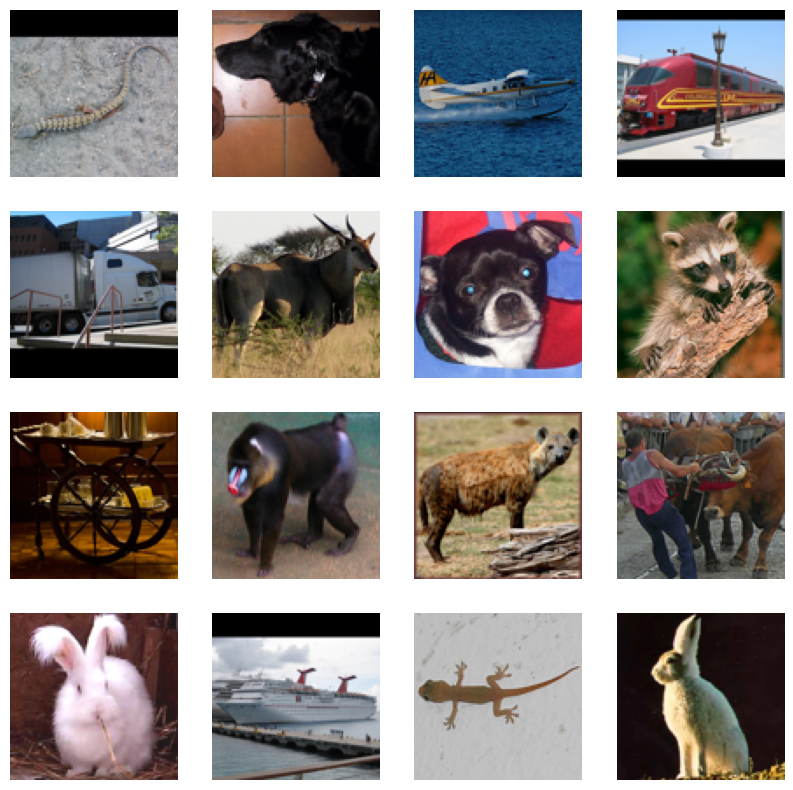

(100000, 96, 96, 3)


In [8]:
data_path = os.path.join(DATA_FOLDER, DATA_FILE)

data = read_data_numpy(data_path)
data = data.astype('float32') / 255.0

visualize_images(data)
print(data.shape)

### Split train and test data

In [9]:
train_images = data[:TRAINING_SET_SIZE]
test_images  = data[TRAINING_SET_SIZE:]

buffer_size       = len(train_images) # buffer size for shuffling
global_batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync # global batch size (in our case 2gpu * BATCH_SIZE_PER_REPLICA)

# create train and test datasets using tf.data API
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(global_batch_size)
test_dataset  = tf.data.Dataset.from_tensor_slices(test_images).batch(global_batch_size)

train_dataset_dist = strategy.experimental_distribute_dataset(train_dataset)
test_dataset_dist  = strategy.experimental_distribute_dataset(test_dataset)

2023-02-27 22:14:36.483659: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 80000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 96
        }
        dim {
          size: 96
        }
        dim {
          size: 3
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT


### Create model

In [10]:
# create a VAE model using the strategy scope to distribute the model on multiple gpus
with strategy.scope():
    vae       = VAE(latent_dim=128) 
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) 

### Training

In [11]:
with strategy.scope():
    @tf.function # compile the function to a graph for faster execution
    def train_step(inputs, vae):
        """Train step function."""
        
        with tf.GradientTape() as tape: # create a tape to record operations
            
            reconstructed = vae(inputs) # forward pass
            loss          = tf.reduce_mean(tf.square(inputs - reconstructed)) # MSE loss (maybe put this in a function)
            gradients     = tape.gradient(loss, vae.trainable_variables) # compute gradients
            
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables)) # gradient descent
        return loss # return loss for logging


In [12]:

for epoch in range(EPOCHS):
    total_loss = 0.0 
    num_batches = 0 
    for inputs in train_dataset_dist: 
        loss = strategy.run(train_step, args=(inputs, vae)) # distributed training
        total_loss += strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=None) # sum losses across replicas
        num_batches += 1 # count number of batches
    train_loss = total_loss / num_batches # compute average loss
    print('Epoch {} train loss: {}'.format(epoch, train_loss))

    total_loss = 0.0
    num_batches = 0
    for inputs in test_dataset_dist: 
        reconstructed = vae(inputs) # forward pass
        loss = tf.reduce_mean(tf.square(inputs - reconstructed)) # MSE loss
        total_loss += strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=None) # sum losses across replicas
        num_batches += 1 # count number of batches
    test_loss = total_loss / num_batches # compute average loss
    print('Epoch {} test loss: {}'.format(epoch, test_loss))

INFO:tensorflow:Error reported to Coordinator: in user code:

    File "/tmp/ipykernel_191918/632996178.py", line 8, in train_step  *
        reconstructed = vae(inputs) # forward pass
    File "/home/ubuntu/data/miniconda3/envs/tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filenvgwdfr0.py", line 11, in tf__call
        (z_mean, z_log_var) = ag__.converted_call(ag__.ld(self).encode, (ag__.ld(inputs),), None, fscope)
    File "/tmp/__autograph_generated_fileq8nlakge.py", line 12, in tf__encode
        z_log_var = ag__.converted_call(ag__.converted_call(ag__.ld(tf).keras.layers.Dense, (ag__.ld(self).latent_dim,), None, fscope), (ag__.ld(z_mean),), None, fscope)

    ValueError: Exception encountered when calling layer 'vae' (type VAE).
    
    in user code:
    
        File "/tmp/ipykernel_191918/412267930.py", line 20, in call  *
            z_mea

ValueError: in user code:

    File "/tmp/ipykernel_191918/632996178.py", line 8, in train_step  *
        reconstructed = vae(inputs) # forward pass
    File "/home/ubuntu/data/miniconda3/envs/tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filenvgwdfr0.py", line 11, in tf__call
        (z_mean, z_log_var) = ag__.converted_call(ag__.ld(self).encode, (ag__.ld(inputs),), None, fscope)
    File "/tmp/__autograph_generated_fileq8nlakge.py", line 12, in tf__encode
        z_log_var = ag__.converted_call(ag__.converted_call(ag__.ld(tf).keras.layers.Dense, (ag__.ld(self).latent_dim,), None, fscope), (ag__.ld(z_mean),), None, fscope)

    ValueError: Exception encountered when calling layer 'vae' (type VAE).
    
    in user code:
    
        File "/tmp/ipykernel_191918/412267930.py", line 20, in call  *
            z_mean, z_log_var = self.encode(inputs) # encode
        File "/tmp/ipykernel_191918/412267930.py", line 30, in encode  *
            z_log_var = tf.keras.layers.Dense(self.latent_dim)(z_mean)
        File "/home/ubuntu/data/miniconda3/envs/tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        ValueError: Exception encountered when calling layer 'dense_1' (type Dense).
        
        Dimensions must be equal, but are 128 and 3 for '{{node replica_1/vae/dense_1/MatMul}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=false](replica_1/vae/encoder/dense_1/BiasAdd, replica_1/vae/dense_1/MatMul/ReadVariableOp)' with input shapes: [64,128], [3,3,3,32].
        
        Call arguments received by layer 'dense_1' (type Dense):
          • inputs=tf.Tensor(shape=(64, 128), dtype=float32)
    
    
    Call arguments received by layer 'vae' (type VAE):
      • inputs=tf.Tensor(shape=(64, 96, 96, 3), dtype=float32)


# Implementing actual model
In this chapter we try to implement the variational image compressing model of the paper on the basis of code written above.

## Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
    """Encoder network for the VAE."""
    
    def __init__(self, N, M):
        """Initializes the encoder."""
        
        super(Encoder, self).__init__()
        self.N      = N
        self.M      = M
        self.conv1  = tf.keras.layers.Conv2D(self.N, 5, activation='relu', strides=2)
        self.conv2  = tf.keras.layers.Conv2D(self.N, 5, activation='relu', strides=2)
        self.conv3  = tf.keras.layers.Conv2D(self.N, 5, activation='relu', strides=2)
        self.conv4  = tf.keras.layers.Conv2D(self.M, 5, activation='relu', strides=2)
        self.gdn1   = tfc.layers.GDN()
        self.gdn2   = tfc.layers.GDN()
        self.gdn3   = tfc.layers.GDN()
    
    def call(self, inputs):
        """Forward pass of the encoder."""
        x = self.conv1(inputs)
        x = self.gdn1(x)
        x = self.conv2(x)
        x = self.gdn2(x)
        x = self.conv3(x)
        x = self.gdn3(x)
        z = self.conv4(x)
        return z

## Hyperprior

## Entropy model

In [156]:
em = tfc.LocationScaleIndexedEntropyModel(
        prior_fn=tfc.NoisyNormal,
        num_scales=10,
        scale_fn = lambda i: i/10,
        coding_rank=2,
     )

indexes    = tf.constant([[1, 10], [100, 1000]])
N = 10000
bottleneck = tf.ones((N, 2, 2))*2

@tf.function(reduce_retracing=True)
def fn(el):
    return em(el, indexes, training=True)[0]

result = tf.vectorized_map(fn, bottleneck)

result = tf.reshape(result, (N, -1))
result.shape

TensorShape([10000, 4])

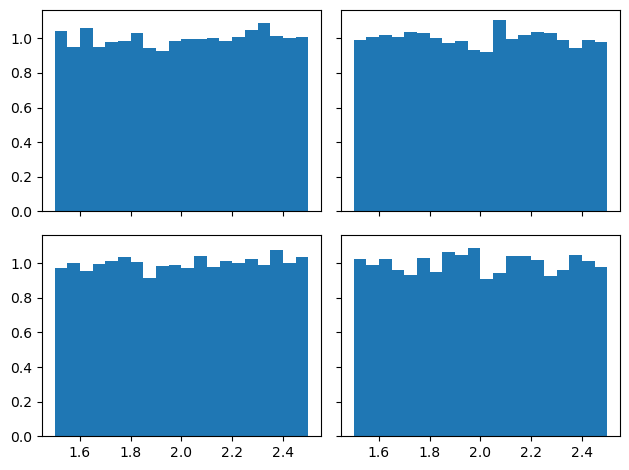

In [157]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, tight_layout=True)
axes = axes.flatten()
for i in range(result.shape[1]):
    axes[i].hist(result[:,i], label=f'{i}', bins=20, density=True)


(-0.5, 0.5)

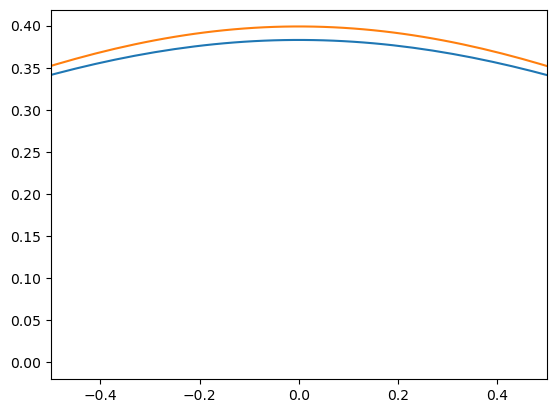

In [10]:
norm = tfp.distributions.Normal(0., 1)
lims = -0.5, 0.5

def conv(x, norm):
    return (norm.cdf(x+lims[1])-norm.cdf(x+lims[0])).numpy()


x = np.linspace(-10, 10, 1000)
y = [conv(e, norm) for e in x]
plt.plot(x, y)
plt.plot(x, norm.prob(x))
plt.xlim(-0.5, 0.5)

In [4]:
noise = tfc.NoisyNormal(loc=2., scale=1.)

2023-03-01 16:24:31.161717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 16:24:31.607787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 16:24:31.609689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 16:24:31.611454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there

(array([  4.,   0.,   1.,   3.,   3.,   6.,   6.,   6.,   9.,   9.,   9.,
         18.,  16.,  19.,  24.,  32.,  25.,  36.,  40.,  48.,  56.,  72.,
         67.,  79.,  87.,  88., 103.,  97., 116., 148., 152., 163., 180.,
        208., 209., 195., 235., 230., 239., 244., 261., 256., 258., 261.,
        268., 269., 311., 296., 294., 296., 277., 263., 262., 230., 254.,
        231., 221., 209., 187., 201., 172., 132., 153., 144., 125., 110.,
        106.,  92.,  87.,  57.,  60.,  50.,  41.,  40.,  38.,  28.,  24.,
         25.,  26.,  14.,  26.,  13.,   8.,   9.,   9.,   4.,   2.,   2.,
          6.,   2.,   2.,   2.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,
          1.]),
 array([-1.43950534, -1.36514163, -1.29077792, -1.21641409, -1.14205039,
        -1.06768668, -0.99332291, -0.9189592 , -0.84459543, -0.77023172,
        -0.69586802, -0.62150425, -0.54714054, -0.4727768 , -0.39841306,
        -0.32404932, -0.24968559, -0.17532185, -0.10095812, -0.02659438,
         0.04776936,  0.12

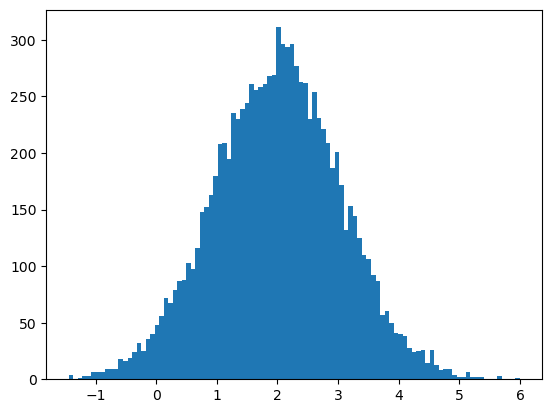

In [9]:
x = noise.sample(10000)

plt.hist(x, bins=100)

In [54]:
norm.cdf(0.1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8413447>

## Decoder

## Full model